In [27]:
data_root = "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/debug/thuman2_36views"
scan_data_root = "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/thuman2"
scan_id = "0000"
rotation = "340"
W, H = 512, 512


intrinsic: [[ 1.73205081  0.          0.          0.        ]
 [ 0.         -1.73205081  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
extrinsic: [[ 0.93969262  0.         -0.34202014  0.00127551]
 [ 0.          1.          0.          0.00113675]
 [ 0.34202014  0.          0.93969262 -1.11959579]
 [ 0.          0.          0.          1.        ]]


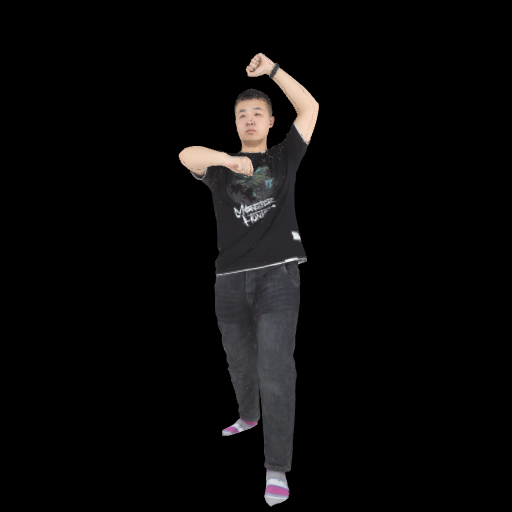

In [28]:
# Use pyrender to test intrinsics and extrinsics matrix.
import pyrender 
import trimesh
import numpy as np
import os.path as osp
import os
from PIL import Image
os.environ['PYOPENGL_PLATFORM'] = 'egl'

# Load camera matrix.
calib = osp.join(data_root, f"{scan_id}/calib/{rotation}.txt")
calib = np.loadtxt(calib)
extrinsic = calib[0:4]
intrinsic = calib[4:]
# scan_scale = intrinsic[0, 0] / np.sqrt(3)
# extrinsic[:3, :4] *= scan_scale

print("intrinsic:", intrinsic)
print("extrinsic:", extrinsic)

# Load scan.
scan = osp.join(scan_data_root, f"scans/{scan_id}/{scan_id}.obj")
mesh = trimesh.load_mesh(scan)
xyzs = mesh.vertices
xyzs = np.concatenate([xyzs, np.ones_like(xyzs[..., :1])], axis=-1)
xyzs = xyzs @ extrinsic.T
mesh.vertices = xyzs[..., :3]
pyrender_mesh = pyrender.Mesh.from_trimesh(mesh)

renderer = pyrender.OffscreenRenderer(viewport_width=W, viewport_height=H)
scene = pyrender.Scene(
    ambient_light=np.array([1.0, 1.0, 1.0, 1.0]),
    bg_color=np.array([0.0, 0.0, 0.0, 0.0]))
# scene.add(pyrender_mesh, pose=extrinsic)
scene.add(pyrender_mesh)

focal = np.sqrt(3)
camera = pyrender.IntrinsicsCamera(
    fx=intrinsic[0, 0] * W / 2.,
    fy=-intrinsic[1, 1] * H / 2.,
    # fx=focal * W / 2.,
    # fy=focal * H / 2.,
    cx=W / 2.,
    cy=H / 2.,
    znear=0.1,
    zfar=100,
)
camera_pose = np.eye(4)
# camera_pose[:3, 3] = [0, 0, 2.0]
scene.add(camera, pose=camera_pose)
# scene.add(camera, pose=extrinsic)
color, depth = renderer.render(scene)

renderer.delete()

Image.fromarray(color)









In [29]:
depth = osp.join(data_root, scan_id, "depth_F", f"{rotation}.npy")
depth = np.load(depth, allow_pickle=True).item()


x = np.linspace(0, 1., W)
y = np.linspace(0, 1., H)
x, y = np.meshgrid(x, y, indexing='xy')
xy = (np.stack([x, y], axis=-1) - 0.5) * 2.
xy = xy[depth["mask"]]

calib = intrinsic @ extrinsic

xyz = np.concatenate([xy, depth["depth"][..., None]], axis=-1)
xyz[..., :2] *= xyz[..., 2:]
xyz[..., 2] = -xyz[..., 2]
xyz = np.concatenate([xyz, np.ones_like(xyz[..., :1])], axis=-1)

xyz = xyz @ np.linalg.inv(calib).T

# xyz = xyz @ np.linalg.inv(extrinsic).T
# xyz = xyz[..., :3]
pcl = trimesh.Trimesh(vertices=xyz)
pcl.export(f"{scan_id}_{rotation}.obj")





'# https://github.com/mikedh/trimesh\nv 0.01937081 0.49129898 0.03917508 1.00000000\nv 0.02204411 0.49076811 0.03943668 1.00000000\nv 0.02431516 0.49078409 0.03857292 1.00000000\nv 0.02644522 0.49099558 0.03730580 1.00000000\nv 0.01621737 0.48697513 0.04474492 1.00000000\nv 0.01867920 0.48672582 0.04443156 1.00000000\nv 0.02053011 0.48729950 0.04241710 1.00000000\nv 0.02257399 0.48761785 0.04092915 1.00000000\nv 0.02465422 0.48789049 0.03953479 1.00000000\nv 0.02674994 0.48814528 0.03817653 1.00000000\nv 0.02878266 0.48849077 0.03662922 1.00000000\nv 0.03088566 0.48874262 0.03527516 1.00000000\nv 0.01493552 0.48323949 0.04829608 1.00000000\nv 0.01742771 0.48294443 0.04808203 1.00000000\nv 0.01936138 0.48339250 0.04632580 1.00000000\nv 0.02091452 0.48435825 0.04349212 1.00000000\nv 0.02284123 0.48483040 0.04168185 1.00000000\nv 0.02482852 0.48522602 0.04002928 1.00000000\nv 0.02717438 0.48513496 0.03938935 1.00000000\nv 0.02954121 0.48501377 0.03881256 1.00000000\nv 0.03161322 0.4853006